In [1]:
%matplotlib widget

# DEFAULTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson
import sys
sys.path.append("..")
from truncation import get_truncation


FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

# plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=False)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor": "None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "dk"},
]

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


df_my = pd.read_csv("deuteron_all_data.csv")
df_my.T21D2 *= 2
df_my.T22D2 *= 2
df_my.T21D *= 2
df_my.T22D *= 2
df_my.AX *= -1
df_my.AX2 *= -1

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in [
    "THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()

# 60 MeV

In [65]:
df_exp = []
for i, fname in enumerate(os.listdir("ExpData/Asymetry/60mev/")):
    df_tmp = pd.read_csv(f'ExpData/Asymetry/60mev/{fname}')
    df_tmp["fname"] = fname.rstrip(".dat")
    df_exp.append(df_tmp)

/tmp/ipykernel_1867434/1114932358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is depre

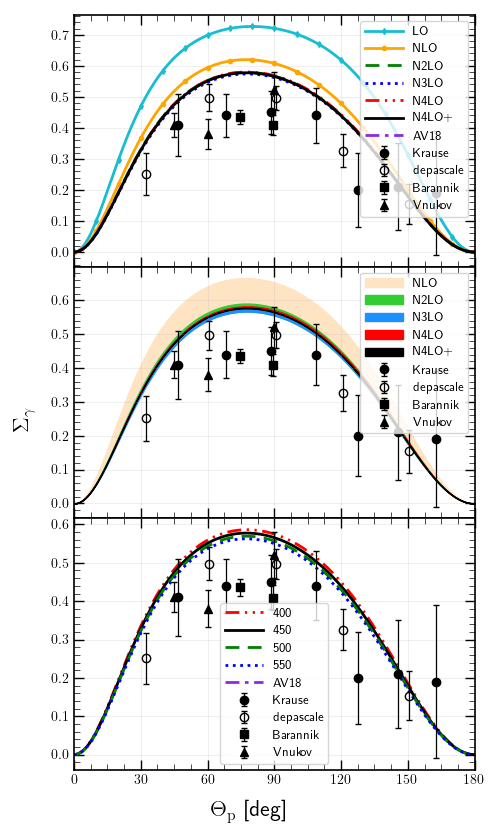

In [66]:
obs="AX2"
energy=60
cutoff=450
df=df_my
wave="SIEGERT"
ylabel="$\Sigma_\gamma$"
df_tmp = df[(df.CUTOFF == cutoff) &
            (df.Energy == energy) &
            (df.WAVE == wave)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
if not ylabel:
    ylabel = obs
fig.supylabel(ylabel, x=0.03, size=16)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) &
                (df.CUTOFF == cutoff) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                            df_tmp[obs].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
    # break
for cut in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") &
                (df.CUTOFF == cut) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                **ls_cutoff[cut], label=cut)
df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for j, ax in enumerate(axes):
    for i, df_tmp in enumerate(df_exp):
        ax.errorbar(df_tmp.theta, df_tmp.Sigma,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common
                    , label=df_tmp.fname[0])
    if j != 1:
        ax.plot(df_av18.angle, df_av18[obs],
                **line_styles["AV18"], label="AV18")

    ax.legend(fontsize=9, handlelength=3, loc="best")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
# plt.savefig(f"../Figures_De/{obs}_{energy}mev.pdf",
#             dpi=600, facecolor="white")

# 20 MeV

In [3]:
df_exp = []
for i, fname in enumerate(os.listdir("ExpData/Asymetry/20mev/")):
    df_tmp = pd.read_csv(f'ExpData/Asymetry/20mev/{fname}')
    df_tmp["fname"] = fname.rstrip(".dat")
    df_tmp["theta"] = 180 - df_tmp["theta_n"]
    df_exp.append(df_tmp)

In [8]:
df_my[df_my["Energy"]==20].FORCE.unique()

array(['N4LO+', 'LO', 'NLO', 'N4LO', 'N2LO', 'N3LO'], dtype=object)

/home/vitalii/anaconda3/envs/experimental/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


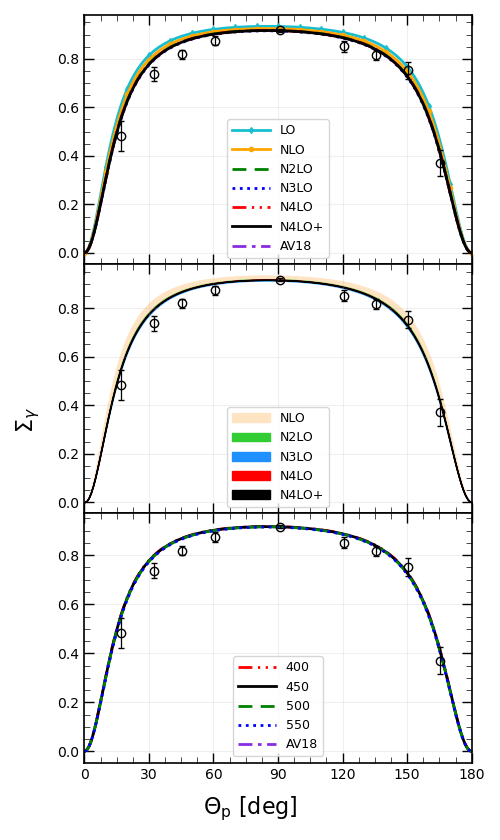

In [12]:
obs="AX2"
energy=20
cutoff=450
df=df_my
wave="SIEGERT"
ylabel="$\Sigma_\gamma$"
df_tmp = df[(df.CUTOFF == cutoff) &
            (df.Energy == energy) &
            (df.WAVE == wave)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
if not ylabel:
    ylabel = obs
fig.supylabel(ylabel, x=0.03, size=16)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) &
                (df.CUTOFF == cutoff) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                            df_tmp[obs].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
    # break
for cut in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") &
                (df.CUTOFF == cut) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                **ls_cutoff[cut], label=cut)
df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for j, ax in enumerate(axes):
    for i, df_tmp in enumerate(df_exp):
        ax.errorbar(df_tmp.theta, df_tmp.Sigma,
                    yerr=df_tmp.error, zorder=3, **exp_style[1], **marker_common)
                    # , label=df_tmp.fname[0])
    if j != 1:
        ax.plot(df_av18.angle, df_av18[obs],
                **line_styles["AV18"], label="AV18")

    ax.legend(fontsize=9, handlelength=3, loc="lower center")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"../Figures_De/{obs}_{energy}mev.pdf",
            dpi=600, facecolor="white")

# 90 deg

In [31]:
df_90 = df_my[(df_my.FORCE == "N4LO+") &
                # (df_my.CUTOFF == 450) &
                (df_my.angle == 90) &
                (df_my.WAVE == "SIEGERT")]
df_90.sort_values("Energy", inplace=True)

In [38]:
df_delbianco = pd.read_csv("ExpData/Asymetry/90deg/delbianco.dat")
df_depascale = pd.read_csv("ExpData/Asymetry/90deg/depascale.dat")

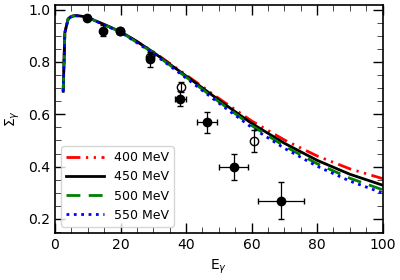

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.8), constrained_layout=True)
for cut in CUTOFF:
    ax.plot(df_90[df_90["CUTOFF"] == cut].Energy,
            df_90[df_90["CUTOFF"] == cut]["AX2"],
            label=f"{cut} MeV",
            **ls_cutoff[cut])
ax.errorbar(df_delbianco.energy, df_delbianco.Sigma,
                    yerr=df_delbianco.error,
            xerr=df_delbianco["energy-error"], zorder=3, **exp_style[0], **marker_common)
ax.errorbar(df_depascale.energy, df_depascale.Sigma,
                    yerr=df_depascale.error, zorder=3, **exp_style[1], **marker_common)
ax.set_xlim([0, 100])
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.tick_params(axis="y", which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4,
            width=0.5, top=True, right=True)
ax.tick_params(which='major', direction='in',
            length=7, width=1, top=True, right=True, zorder=1)
ax.legend(fontsize=9, handlelength=3, loc="lower left")
ax.set_ylabel("$\Sigma_\gamma$")
ax.set_xlabel("E$_\gamma$")
plt.show()
fig.savefig("../Figures_De/AX2_90deg.pdf",
            dpi=600, facecolor="white")

In [46]:
MN=939.5653
MP=938.2720
MM=2.0*MP*MN/(MP+MN)
absb2= 2.225
md=2*MM-absb2

In [76]:
OMEGACM= (-2*MM*md + np.sqrt(2.)*np.sqrt(-4*absb2*MM**2*md + 8*MM**3*md - 
2*MM**2*md**2 + 4*MM**2*md*omegalab - MM*md*omegalab**2))/(2.*MM)

In [74]:
omegalab=np.arange(0,150,0.1)

In [81]:
omegacm= (np.sqrt(md)*omegalab)/np.sqrt(md + 2*omegalab) #relativistically

In [85]:
T=2*(omegacm + md + omegacm**2/2/md - 2*MM)

In [89]:
omegalab[np.argmin(np.abs(T-180))]

94.5

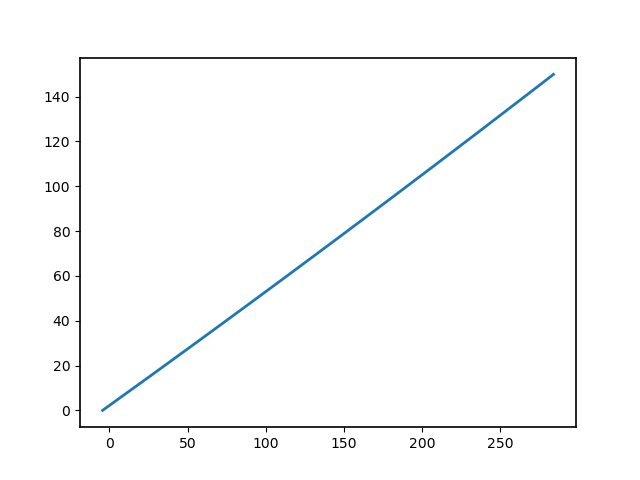

In [90]:
plt.figure()
plt.plot(T, omegalab)
plt.show()

In [3]:
df_cameron=pd.read_csv("ExpData/Capture_analyzing/cameron.dat")

In [8]:
df_tmp = pd.read_csv("../../../test/2.dat5.5.2.100mev_neuteron", skiprows=1, delim_whitespace=True,
                    names=["THCM", "CROSSCAP", "CROSSCAP2", "AYN1CAP", "AYN1CAP2"])

In [9]:
df_tmp.head()

,THCM,CROSSCAP,CROSSCAP2,AYN1CAP,AYN1CAP2
0,0.0000,0.2126,0.5177,-0.0,-5.318000e-33
1,0.0175,0.2126,0.5177,-0.0,-2.146000e-03
2,0.0349,0.2129,0.5176,-0.0,-4.291000e-03
3,0.0524,0.2134,0.5176,-0.0,-6.433000e-03
4,0.0698,0.2140,0.5175,0.0,-8.570000e-03


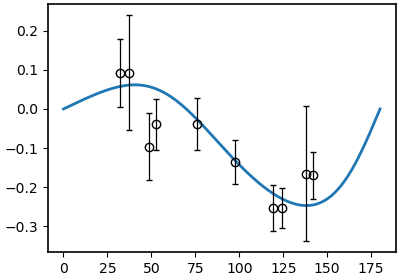

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.8), constrained_layout=True)
ax.plot(df_tmp.THCM*180/np.pi, -df_tmp["AYN1CAP2"])
ax.errorbar(df_cameron.theta, df_cameron.Ay,
                    yerr=df_cameron["Ay-error"], zorder=3, **exp_style[1], **marker_common)
plt.show()